In [32]:
from datetime import datetime as dt, timedelta
import numpy as np
import pandas as pd
import math
import matplotlib.dates as mdates
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [33]:
pwd

'/Users/thanhbed/Documents/GitHub/CoastGuard'

In [34]:
def wind_data(df,Wdf):
    df["GMT_Time"] = pd.to_datetime(df["GMT_Time"]) + timedelta(hours=12)
    df["dtime"] = df["GMT_Time"].diff()
    df.dtime = df.dtime.dt.total_seconds()
    df['LW_NS']= df['yW_LO'].diff()/df.dtime
    df['LW_EW'] = df['xN_LO'].diff()/df.dtime
    df.dtime[0] = df.dtime[1]
    df.LW_EW[0] = df.LW_EW[1]
    df.LW_NS[0] = df.LW_NS[1]
    df = df[df.dtime != 0]  
    df = df.reset_index(drop=True)
    df['LW_Speed'] = (df.LW_EW*df.LW_EW + df.LW_NS*df.LW_NS)**(0.5)
    df['LW_Theta'] = np.degrees(np.arctan(df.LW_EW/df.LW_NS))
#     df['LW_Theta'] = np.degrees(np.arctan(df.LW_NS/df.LW_EW))
    Wdf["Time"] = pd.to_datetime(Wdf["Time"])
    Wdf["Time"] = Wdf["Time"].dt.time
    Wdf.Time = pd.to_datetime( Wdf.Time.astype(str))
    threshold = pd.to_datetime(400000000)-pd.to_datetime(100000000)
    df['Wind_NS'] = float(0.00)
    df['Wind_EW'] = float(0.00)
    df['Wind_Speed'] = float(0.00)
    df['Wind_Theta'] = float(0.00)

    c = 0
    l = df.shape[0]
    print(l)

    for i in range (l):
        diff = abs(df['GMT_Time'][i] - Wdf['Time'][c])
        while diff > threshold:
            c = c+1
            diff = abs(df['GMT_Time'][i] - Wdf['Time'][c])
        df['Wind_NS'][i] = Wdf['Wind_NS'][c]
        df['Wind_EW'][i] = Wdf['Wind_EW'][c]
        df['Wind_Speed'][i] = Wdf['Wind_Speed'][c]
        df['Wind_Theta'][i] = Wdf['Wind_Theta'][c]
        c = c+1
    df["Theta_diff"] = df.Wind_Theta - df.LW_Theta
    df["Speed_diff"] = df.Wind_Speed - df.LW_Speed
#     df["driftx"]=df.slopex/df.wind_EW
#     df["drifty"]=df.slopey/df.wind_NS
    return df

def old_data_time_average(df,time = 20):
    avg_df = pd.DataFrame()
    a = time; al = int(len(df)/a)+1
    print(al);c = 0
    for i in range(al):
        avg_df = avg_df.append({'GMT_Time':df['GMT_Time'][c:(c+a)].mean(),
                                'LW_EW':df['LW_EW'][c:(c+a)].mean(),
                                'LW_NS':df['LW_NS'][c:(c+a)].mean(),
                                'LW_Speed':df['LW_Speed'][c:(c+a)].mean(),
                                'LW_Theta':df['LW_Theta'][c:(c+a)].mean(),
                                'Wind_NS':df['Wind_NS'][c:(c+a)].mean(),
                                'Wind_EW':df['Wind_EW'][c:(c+a)].mean(),
                                'Wind_Speed':df['Wind_Speed'][c:(c+a)].mean(),
                                'Wind_Theta':df['Wind_Theta'][c:(c+a)].mean(),
                                'Theta_diff':df['Theta_diff'][c:(c+a)].mean(),
                                'Speed_diff':df['Speed_diff'][c:(c+a)].mean(),
#                                 'LW_EW':df['LW_EW'][c:(c+a)].mean(),
#                                 'LW_NS':df['LW_NS'][c:(c+a)].mean(),
                               }, ignore_index = True)
        c = c+a
    avg_df["LW_EW_drift"]=avg_df.LW_EW/avg_df.Wind_EW
    avg_df["LW_NS_drift"]=avg_df.LW_NS/avg_df.Wind_NS
    return avg_df

def data_time_average(df,time = 20):
    avg_df = pd.DataFrame()
    a = time; al = int(len(df)/a)+1
    print(al);c = 0
    for i in range(al):
        avg_df = avg_df.append({'GMT_Time':df['GMT_Time'][c:(c+a)].mean(),
                                'xN_LO':df['xN_LO'][c:(c+a)].mean(),
                                'yW_LO':df['yW_LO'][c:(c+a)].mean(),
                                'Wind_NS':df['Wind_NS'][c:(c+a)].mean(),
                                'Wind_EW':df['Wind_EW'][c:(c+a)].mean(),
                               }, ignore_index = True)
        c = c+a

    avg_df["GMT_Time"] = pd.to_datetime(avg_df["GMT_Time"]) + timedelta(hours=12)
    avg_df["dtime"] = avg_df["GMT_Time"].diff()
    avg_df.dtime = avg_df.dtime.dt.total_seconds()
    avg_df['LW_NS']= avg_df['yW_LO'].diff()/avg_df.dtime
    avg_df['LW_EW'] = avg_df['xN_LO'].diff()/avg_df.dtime
    avg_df['LW_Speed'] = (avg_df.LW_EW*avg_df.LW_EW + avg_df.LW_NS*avg_df.LW_NS)**(0.5)
    avg_df['LW_Theta'] = np.degrees(np.arctan(avg_df.LW_EW/avg_df.LW_NS))
    avg_df['Wind_Speed'] = (avg_df.Wind_NS*avg_df.Wind_NS + avg_df.Wind_EW*avg_df.Wind_EW)**(0.5)
    avg_df['Wind_Theta'] = np.degrees(np.arctan(avg_df.Wind_EW/avg_df.Wind_NS))
    avg_df["LW_EW_drift"]=avg_df.LW_EW/avg_df.Wind_EW
    avg_df["LW_NS_drift"]=avg_df.LW_NS/avg_df.Wind_NS
    avg_df["Theta_diff"] = abs(avg_df.Wind_Theta - avg_df.LW_Theta)
    avg_df["Speed_diff"] = avg_df.Wind_Speed - avg_df.LW_Speed
    return avg_df

def compare_plot(y1,y2,name,ylabel,label1,label2):
    x = []
    time = ((data["GMT_Time"].round("S")).dt.time)
    for i in time:
        x.append(str(i))
    t = len(data)
    fig, ax = plt.subplots(figsize=(15, 10))
    plt.plot(x[1:t],y1[1:t],"*-",label=label1)
    plt.plot(x[1:t],y2[1:t],"o-",label=label2)
    # ax.plot(x,np.zeros(t))
    _=plt.xticks(rotation=45)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    plt.xlabel('GMT Time',size = 15)
    plt.ylabel(ylabel,size = 15)
    ax.set_xticks(ax.get_xticks()[::1])
    # plt.title(name,size = 30)
    plt.legend()
    plt.savefig("./Plots/"+name)

In [44]:
# Wdf = pd.read_csv("./Data/wind_data_processed.csv")

# df = pd.read_excel("./Data/Mannequin_Time_lat_lon_xN_yW (GV3_P1_MS1).xlsx")
# Mdf1 = wind_data(df,Wdf)

# df=pd.read_excel("./Data/Mannequin_Time_lat_lon_xN_yW (GV3_P1_MS2).xlsx")
# Mdf2 = wind_data(df,Wdf)

# df=pd.read_excel("./Data/Pelican_Time_lat_lon_xN_yW (GV3_P1_MS1).xlsx")
# Pdf1 = wind_data(df,Wdf)

# df=pd.read_excel("./Data/Pelican_Time_lat_lon_xN_yW (GV3_P1_MS2).xlsx")
# Pdf2 = wind_data(df,Wdf)
# Mdf2.head()

In [56]:
Wdf = pd.read_csv("./Data/wind_data_processed.csv")

df =pd.read_excel("./Data/Leeway_Est_Separated_Images_GV3_Part_2/Mannequin_Time_lat_lon_xN_yW (GV3_P2_MS1).xlsx")
Mdf1 = wind_data(df,Wdf)

df =pd.read_excel("./Data/Leeway_Est_Separated_Images_GV3_Part_2/Mannequin_Time_lat_lon_xN_yW (GV3_P2_MS2).xlsx")
Mdf2 = wind_data(df,Wdf)


df =pd.read_excel("./Data/Leeway_Est_Separated_Images_GV3_Part_2/Pelican_Time_lat_lon_xN_yW (GV3_P2_MS1).xlsx")
Pdf1 = wind_data(df,Wdf)

df =pd.read_excel("./Data/Leeway_Est_Separated_Images_GV3_Part_2/Pelican_Time_lat_lon_xN_yW (GV3_P2_MS2).xlsx")
Pdf2 = wind_data(df,Wdf)


253
244
102
29


In [57]:
Mdf = pd.concat([Mdf1,Mdf2])
Mdf = Mdf.reset_index(drop=True)
Mdf = Mdf.sort_values(by = 'GMT_Time')
Mdf = Mdf.reset_index(drop=True)
Mdf


Pdf = pd.concat([Pdf1,Pdf2])
Pdf = Pdf.reset_index(drop=True)
Pdf = Pdf.sort_values(by = 'GMT_Time')
Pdf = Pdf.reset_index(drop=True)
Pdf

,GMT_Time,LO_lat,LO_lon,xN_LO,yW_LO,dtime,LW_NS,LW_EW,LW_Speed,LW_Theta,Wind_NS,Wind_EW,Wind_Speed,Wind_Theta,Theta_diff,Speed_diff
0,2021-08-03 19:28:37.615,29.343301,-94.852002,-11.606857,44.280998,1.200,-0.540896,0.236874,0.590490,-23.649999,-5.547495,5.059493,7.508207,-42.365817,-18.715818,6.917717
1,2021-08-03 19:28:38.815,29.343303,-94.851995,-11.322608,43.631923,1.200,-0.540896,0.236874,0.590490,-23.649999,-5.222939,4.242249,6.728727,-39.084675,-15.434676,6.138238
2,2021-08-03 19:28:40.015,29.343280,-94.852003,-13.875726,44.415371,1.200,0.652873,-2.127598,2.225515,-72.940884,-6.204074,3.303047,7.028560,-28.030821,44.910064,4.803044
3,2021-08-03 19:28:41.215,29.343283,-94.851995,-13.582338,43.619352,1.200,-0.663349,0.244490,0.706970,-20.232355,-5.918600,4.499427,7.434693,-37.242755,-17.010400,6.727723
4,2021-08-03 19:28:42.415,29.343298,-94.851978,-11.899852,41.930961,1.200,-1.406993,1.402072,1.986312,-44.899628,-4.990744,3.768107,6.253492,-37.053500,7.846128,4.267180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,2021-08-03 19:39:57.410,29.340854,-94.851643,-282.744156,9.405364,1.201,-0.158286,-0.672873,0.691240,76.762493,-1.018256,-5.749097,5.838575,79.956170,3.193677,5.147335
127,2021-08-03 19:39:58.610,29.340765,-94.851737,-292.602658,18.563529,1.200,7.631804,-8.215419,11.213275,-47.109112,-2.061421,-6.313540,6.641554,71.917727,119.026839,-4.571721
128,2021-08-03 19:40:01.009,29.340828,-94.851641,-285.691806,9.210786,2.399,-3.898600,2.880722,4.847437,-36.461135,-2.134790,-5.221859,5.641378,67.764378,104.225512,0.793941
129,2021-08-03 20:06:20.418,29.335717,-94.852089,-852.190459,52.715045,1732.702,0.022131,-0.393109,0.393731,-86.777795,0.385813,-4.708825,4.724604,-85.315988,1.461807,4.330872


14
Pelican Galveston3 Part 2 - Time Averaged Leeway's Utheta vs Wind's Utheta
Pelican Galveston3 Part 2 - Time Averaged Leeway's Velocity vs Wind's Velocity
Pelican Galveston3 Part 2 - Time Averaged Drift
Pelican Galveston3 Part 2 - Time Averaged NS Velocity
Pelican Galveston3 Part 2 - Time Averaged EW Velocity


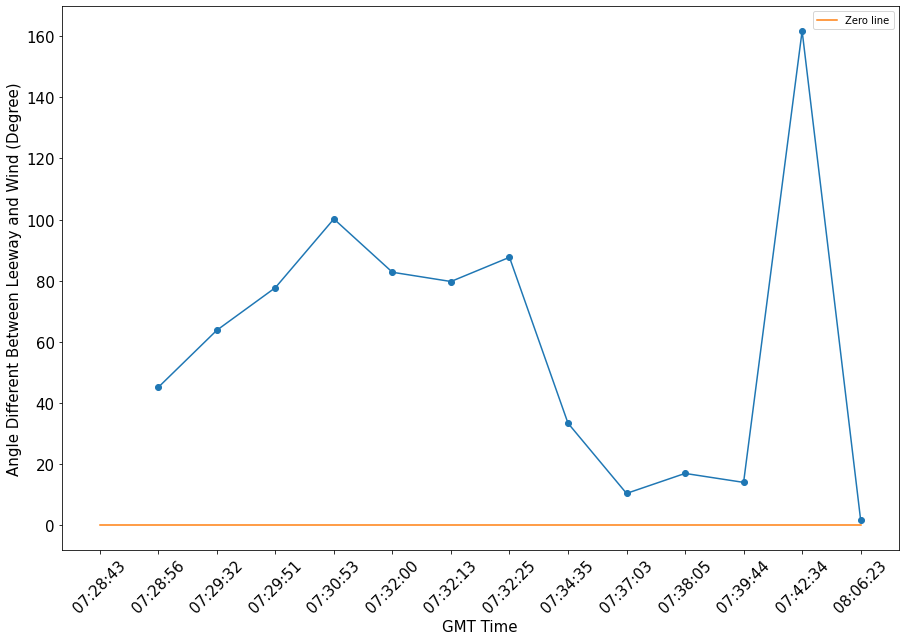

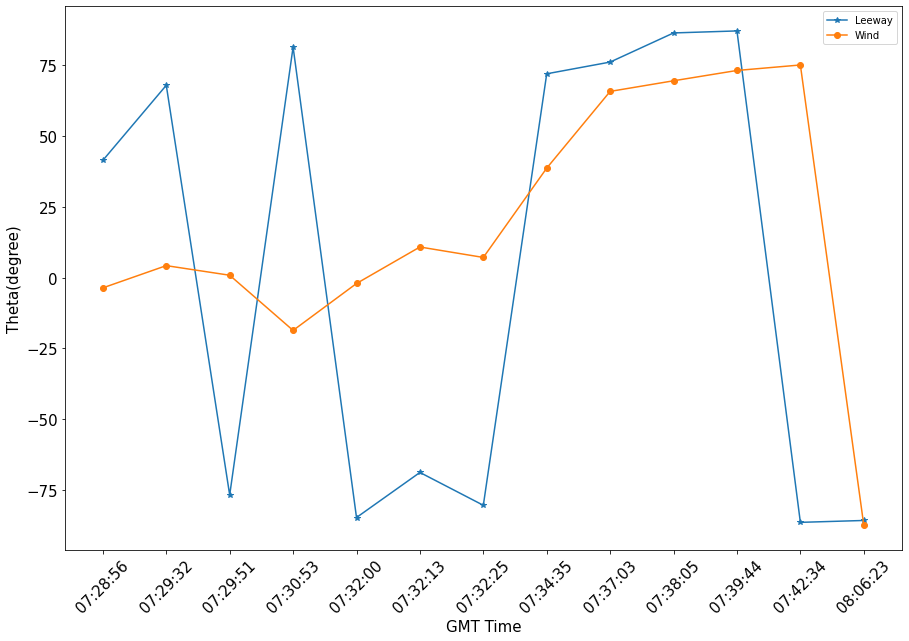

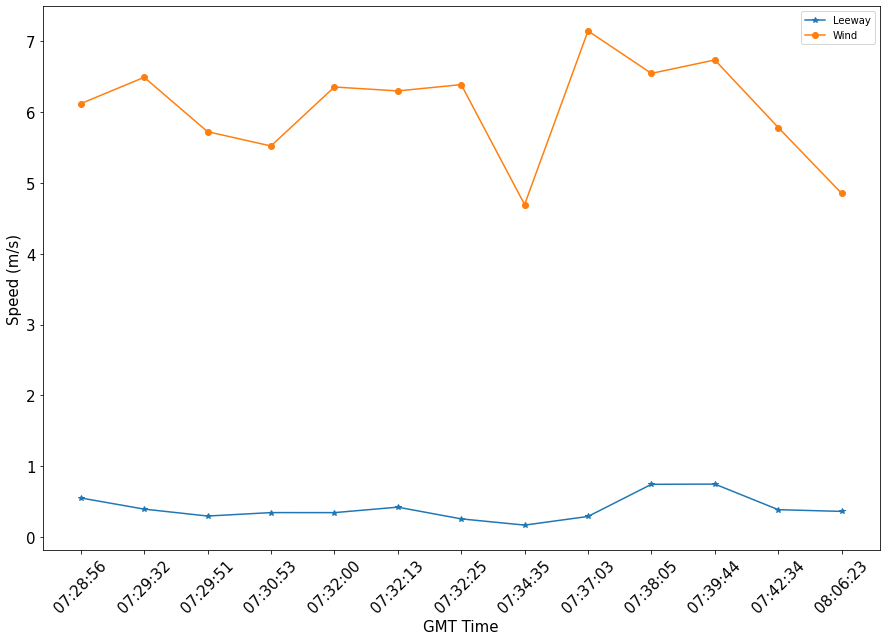

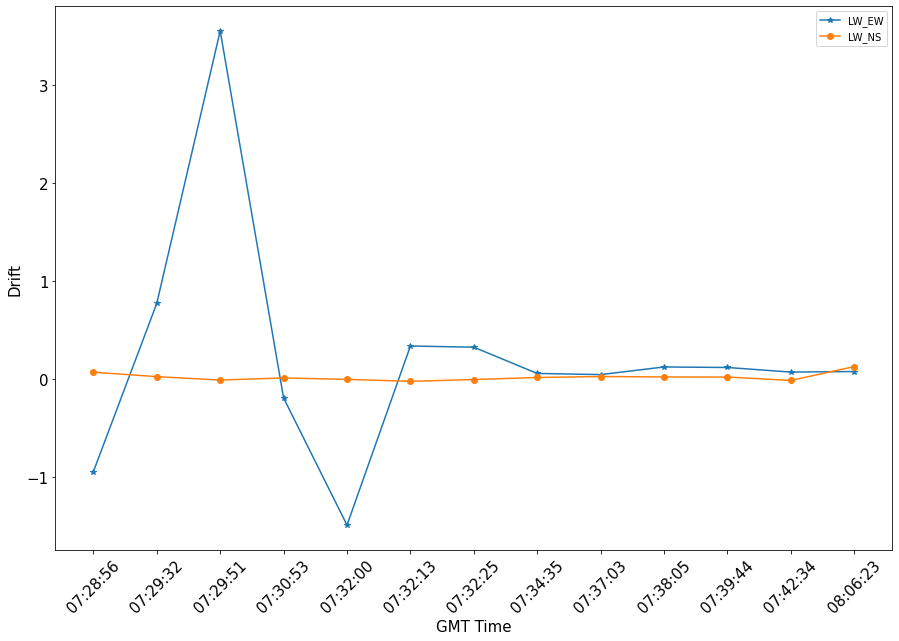

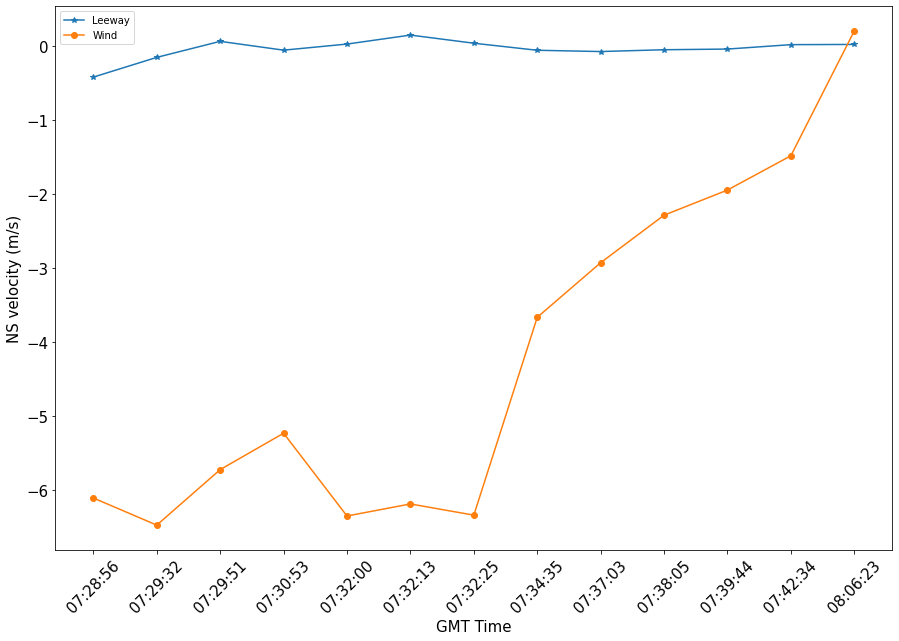

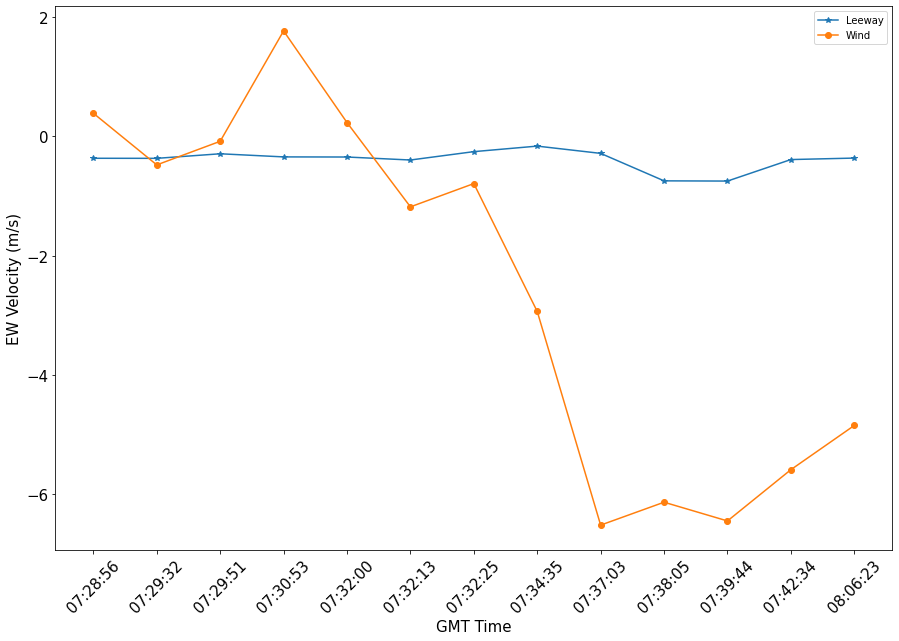

In [64]:
data = data_time_average(Pdf,time = 10)
# dataname = "Mannequin Galveston3 Part 2"
dataname = "Pelican Galveston3 Part 2"


name = dataname+" - Time Averaged Utheta Diffrent Between Wind-Utheta and Leeway Object"
y = data.Theta_diff
x = []
time = ((data["GMT_Time"].round("S")).dt.time)
for i in time:
    x.append(str(i))
t = len(data)
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(x[:t],y[:t],"o-")
ax.plot(x,np.zeros(t),label = 'Zero line')
_=plt.xticks(rotation=45)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.xlabel('GMT Time',size = 15)
plt.ylabel('Angle Different Between Leeway and Wind (Degree)',size = 15)
ax.set_xticks(ax.get_xticks()[::1])
plt.legend()
plt.savefig("./Plots/"+name)

name = dataname+" - Time Averaged Leeway's Utheta vs Wind's Utheta"
print(name)
y1 = data.LW_Theta
y2 = data.Wind_Theta
ylabel = 'Theta(degree)'
label1="Leeway"
label2="Wind"
compare_plot(y1,y2,name,ylabel,label1,label2)
    
name = dataname+" - Time Averaged Leeway's Velocity vs Wind's Velocity"
print(name)
y1 = data.LW_Speed
y2 = data.Wind_Speed
ylabel = 'Speed (m/s)'
label1="Leeway"
label2="Wind"
compare_plot(y1,y2,name,ylabel,label1,label2)

name = dataname+" - Time Averaged Drift"
print(name)
y1 = data.LW_EW_drift
y2 = data.LW_NS_drift
ylabel = 'Drift'
label1="LW_EW"
label2="LW_NS"
compare_plot(y1,y2,name,ylabel,label1,label2)

name = dataname+" - Time Averaged NS Velocity"
print(name)
y1 = data.LW_NS
y2 = data.Wind_NS
ylabel = 'NS velocity (m/s)'
label1="Leeway"
label2="Wind"
compare_plot(y1,y2,name,ylabel,label1,label2)

name = dataname+" - Time Averaged EW Velocity"
print(name)
y1 = data.LW_EW
y2 = data.Wind_EW
ylabel = 'EW Velocity (m/s)'
label1="Leeway"
label2="Wind"
compare_plot(y1,y2,name,ylabel,label1,label2)

In [51]:
# Man_df1=pd.read_excel("./Data/Mannequin_Time_lat_lon_xN_yW (GV3_P1_MS1).xlsx")

# Man_df2=pd.read_excel("./Data/Mannequin_Time_lat_lon_xN_yW (GV3_P1_MS2).xlsx")

# Pel_df1=pd.read_excel("./Data/Pelican_Time_lat_lon_xN_yW (GV3_P1_MS1).xlsx")

# Pel_df2=pd.read_excel("./Data/Pelican_Time_lat_lon_xN_yW (GV3_P1_MS2).xlsx")

# test1 = Man_df1.rename(columns={"LO_lat": "LO_lat_m1", "LO_lon": "LO_lon_m1"})
# test2 = Man_df2.rename(columns={"LO_lat": "LO_lat_m2", "LO_lon": "LO_lon_m2"})
# test3 = Pel_df1.rename(columns={"LO_lat": "LO_lat_p1", "LO_lon": "LO_lon_p1"})
# test4 = Pel_df2.rename(columns={"LO_lat": "LO_lat_p2", "LO_lon": "LO_lon_p2"})

# frames = [test1, test2,test3,test4]
# totaldata = pd.concat(frames)
# totaldata=totaldata.sort_values(by=['GMT_Time'])
# totaldata = totaldata.drop(columns=['xN_LO', 'yW_LO'])
# totaldata

# %pip install plotly

# import pandas as pd
# df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/earthquakes-23k.csv')

# import plotly.graph_objects as go

# data = Man_df1
# lable = "Mannequin 1"
# color = "red"
# fig = go.Figure(go.Scattermapbox(mode = "markers+lines", lat=data['LO_lat'], 
#     lon=data['LO_lon'],marker = {"color":color,'size': 5},name=lable))

# data = Man_df2
# lable = "Mannequin 2"
# color = "blue"
# fig.add_trace(go.Scattermapbox(mode = "markers+lines", lat=data['LO_lat'], 
#     lon=data['LO_lon'],marker = {"color":color,'size': 5},name=lable))

# data = Pel_df1
# lable = "Penlican 1"
# color = "Magenta"
# fig.add_trace(go.Scattermapbox(mode = "markers+lines", lat=data['LO_lat'], 
#     lon=data['LO_lon'],marker = {"color":color,'size': 5},name=lable))

# data = Pel_df2
# lable = "Penlican 2"
# color = "Green"
# fig.add_trace(go.Scattermapbox(mode = "markers+lines", lat=data['LO_lat'], 
#     lon=data['LO_lon'],marker = {"color":color,'size': 5},name=lable))


# fig.update_layout(
#     mapbox_style="white-bg",
#     mapbox_layers=[
#         {
#             "below": 'traces',
#             "sourcetype": "raster",
#             "sourceattribution": "United States Geological Survey",
#             "source": ["https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"]
#         }
#       ])

# fig.update_layout(margin={"r":5,"t":5,"l":5,"b":5},
#                   mapbox = {'center': {'lon': -94.8525, 'lat': 29.348},'zoom': 15})

# # fig.update_xaxes(title_text='Time')
# # plt.savefig('traj1-pelican.png')

# fig.update_layout(
#     autosize=False,
#     width=800,
#     height=800,)
# fig.show()

# ## Plot LatLong Plot over Time
# data = Man_df2
# name = "Mannequin_2"
# time = np.array(data["GMT_Time"])
# s = 10

# current_directory = os.getcwd()
# final_directory = os.path.join(current_directory, r'Plots/'+name)
# if not os.path.exists(final_directory):
#    os.makedirs(final_directory)

# ymax = np.max(data['LO_lat'])
# ymin = np.min(data['LO_lat'])

# xmax = np.max(data['LO_lon'])
# xmin = np.min(data['LO_lon'])
# skip = 10

# for t in range(0,np.shape(time)[0],skip):
#     filename = './Plots/'+name+"//"+str(t)+'.png'
#     y = data['LO_lat'][:t]
#     x = data['LO_lon'][:t]
#     plt.subplots(figsize=(s, s*2))
#     plt.ylim([ymin, ymax])
#     plt.xlim([xmin, xmax])
#     plt.plot(x,y,'-om')
#     plt.xlabel('E-W longitude', fontsize=18)
#     plt.ylabel('N-S latitdue', fontsize=18)
# #     plt.title('Oscar1 16.38 GMT- 19.01 GMT (0 is location of boat at initial time)')
#     plt.title(name+'GMT-'+time[t], fontsize=18)
#     plt.savefig(filename)
# #     plt.show()
#     plt.close() 

In [52]:
# df = df1

In [57]:
modelx=np.polyfit(df.wind_EW, df.slopex,1)
predictx=np.poly1d(modelx)
predictx

poly1d([ 0.00117809, -0.24592574])

In [58]:
test1=df.wind_Ur
test2=df.Ur
model1=np.polyfit(test1,test2,1)
modelx=np.polyfit(df.wind_EW, df.slopex,1)
modely=np.polyfit(df.wind_NS, df.slopey,1)

In [59]:
# test1[wf2.wind_speed>2.0]

In [60]:
model1,modelx,modely

(array([-0.09359601,  1.9571471 ]),
 array([ 0.00117809, -0.24592574]),
 array([-0.00193458, -0.04633093]))

(0.0, 5.0)

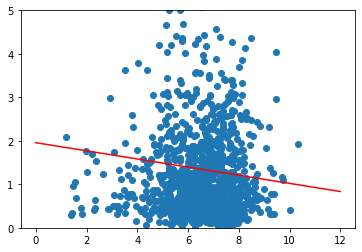

In [61]:
predict1=np.poly1d(model1)
predictx=np.poly1d(modelx)
predicty=np.poly1d(modely)

l = len(df1)

x1=np.arange(0,12,12./l)
y1=predict1(x1)
yx=predictx(x1)
yy=predicty(x1)
plt.plot(x1,y1,c='r')
plt.scatter(df.wind_Ur,df.Ur)
plt.ylim((0,5))

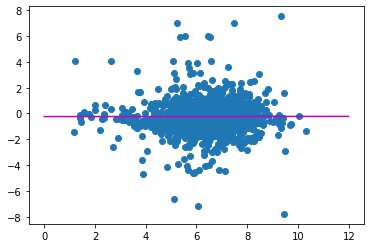

In [62]:
plt.plot(x1,yx,c='m')
plt.scatter((df.wind_Ur),(df.slopex))

In [63]:
ssr = np.sum((y1 - df.Ur)**2)

sst = np.sum((df.Ur - np.mean(df.Ur))**2)

r2_score = 1 - (ssr/sst)

In [64]:
r2_score

0.030217018495667602

In [65]:
np.corrcoef(df.Ur,df.wind_Ur)

array([[ 1.        , -0.08224997],
       [-0.08224997,  1.        ]])

In [76]:
a = np.mean(np.array(df.Ur/df.wind_Ur))
print(a)

0.2309807275384177


Text(0.5, 1.0, 'Pelican:lws/ws=0.19, ld/ws=0.08')

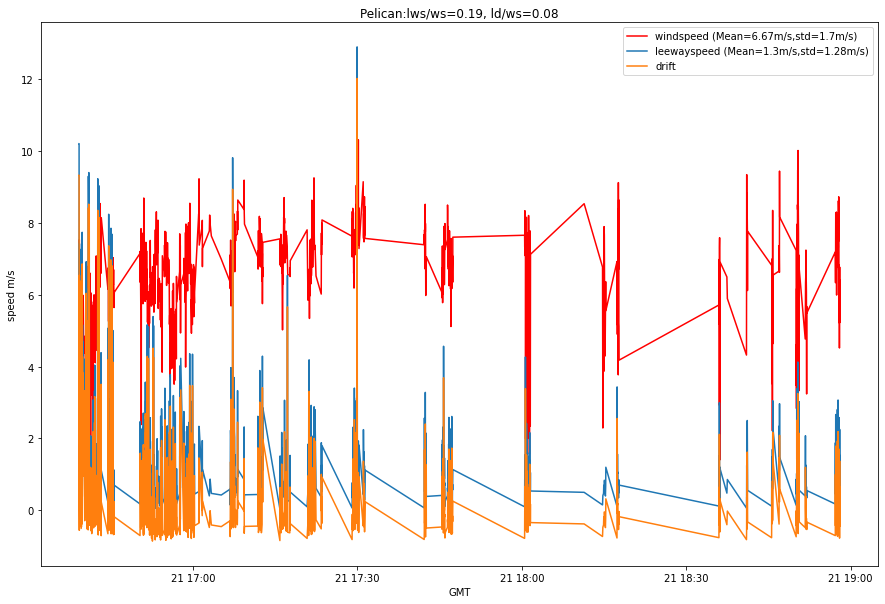

In [78]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(df.GMT_Time, df.wind_Ur,'r',label='windspeed (Mean=6.67m/s,std=1.7m/s)')
plt.plot(df.GMT_Time, (df.Ur),label='leewayspeed (Mean=1.3m/s,std=1.28m/s)')
plt.plot(df.GMT_Time, (df.Ur-0.88),label='drift')
plt.legend()
plt.xlabel('GMT')
plt.ylabel('speed m/s')
plt.title('Pelican:lws/ws=0.19, ld/ws=0.08')
# plt.savefig("lwdset2.png")

In [774]:
np.mean(wf2.wind_speed[1:800]), np.std(wf2.wind_speed[1:800]),1.3/6.7,0.53/6.6,np.mean(df.lwv[1:800]-0.77), np.std(df.lwv[1:800])

(6.670748196943172,
 1.7189571124103495,
 0.19402985074626866,
 0.0803030303030303,
 0.534667448856788,
 1.2842900119112772)

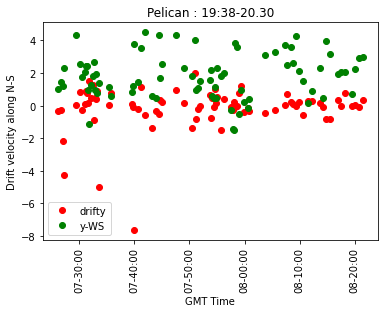

In [785]:
fig, ax = plt.subplots()
ax.plot(df.GMT_Time[1:800:10],df.slopey[1:800:10],'ro',label='drifty')
ax.plot(df.GMT_Time[1:800:10],wf2.wind_y_velocity[1:800:10],'go',label='y-WS')
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H-%M:%S"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H-%M-%S"))
_=plt.xticks(rotation=90)    
plt.xlabel('GMT Time')
plt.ylabel('Drift velocity along N-S')
plt.title('Pelican : 19:38-20.30')
plt.legend()
plt.savefig('y-drift velocity-Pelican')


In [786]:
np.corrcoef(wf2.wind_speed[1:800], df.slopey[1:800])

array([[ 1.       , -0.0345015],
       [-0.0345015,  1.       ]])

In [778]:
(df["GMT_Time"].dt.minute).mean()

32.736160188457006

In [779]:
df.sdf["GMT_Time"].dt.hour])["lwv"].mean()*1.943

GMT_Time
7    2.257313
8    3.266418
Name: lwv, dtype: float64

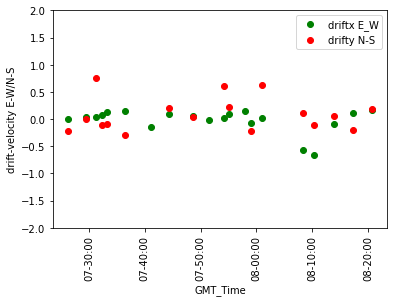

In [784]:
fig, ax = plt.subplots()
ax.plot(df.GMT_Time[1:800],df.driftx[1:800],'go',label='driftx E_W')
ax.plot(df.GMT_Time[1:800], df.drifty[1:800],'ro',label='drifty N-S')
#ax.plot(df.GMT_Time[1:800], df.lwv[1:800],'kx')
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H-%M:%S"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H-%M-%S"))
_=plt.xticks(rotation=90) 
plt.xlabel('GMT_Time')
plt.ylabel('drift-velocity E-W/N-S')
plt.legend()
plt.ylim(-2,2)
plt.savefig('pelican-drift')


No handles with labels found to put in legend.


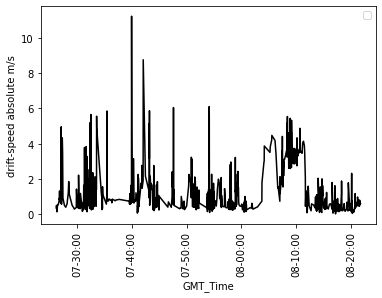

In [739]:
fig, ax = plt.subplots()
ax.plot(df.GMT_Time[1:800], df.lwv[1:800],'k-')
#ax.plot(df.GMT_Time,df.drifty,'b-o')
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H-%M:%S"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H-%M-%S"))
_=plt.xticks(rotation=90) 
plt.xlabel('GMT_Time')
plt.ylabel('drift-speed absolute m/s')
plt.legend()
plt.savefig('pelican-drift-total')


In [148]:
wd1_dna["GMT_Time"] = pd.to_datetime(wd1_dna['time'])

In [369]:
wd1_dna

,time,wind_x_velocity,wind_y_velocity,wind_speed,heading,latitude,longitude,wind_polar_r,wind_polar_radians,GMT_Time
0,2021-04-18 16:39:12.034606336,-5.238559,2.49544,5.802563,54.594,29.349991,-94.852417,5.802563,0.858493,2021-04-18 16:39:12.034606336
1,2021-04-18 16:39:12.134736896,-5.428308,2.63294,6.033149,54.594,29.349991,-94.852417,6.033149,0.856249,2021-04-18 16:39:12.134736896
2,2021-04-18 16:39:12.237749504,-5.554867,2.69879,6.175761,54.594,29.349991,-94.852417,6.175761,0.856042,2021-04-18 16:39:12.237749504
3,2021-04-18 16:39:12.340727296,-5.905380,2.69127,6.489716,54.716,29.349991,-94.852416,6.489716,0.863888,2021-04-18 16:39:12.340727296
4,2021-04-18 16:39:12.435150080,-5.240006,2.42095,5.772231,54.716,29.349991,-94.852416,5.772231,0.862236,2021-04-18 16:39:12.435150080
...,...,...,...,...,...,...,...,...,...,...
75808,2021-04-18 18:53:41.836144384,-6.284467,3.35058,7.350619,75.722,29.344102,-94.851817,7.121861,0.844087,2021-04-18 18:53:41.836144384
75809,2021-04-18 18:53:41.934479104,-6.291549,3.70684,6.569358,75.722,29.344102,-94.851817,7.302344,0.830524,2021-04-18 18:53:41.934479104
75810,2021-04-18 18:53:42.034369792,-5.945097,2.53784,7.104393,75.394,29.344101,-94.851817,6.464116,0.871574,2021-04-18 18:53:42.034369792
75811,2021-04-18 18:53:42.134696448,-6.063230,0.75855,7.733490,75.394,29.344101,-94.851817,6.110495,0.960383,2021-04-18 18:53:42.134696448


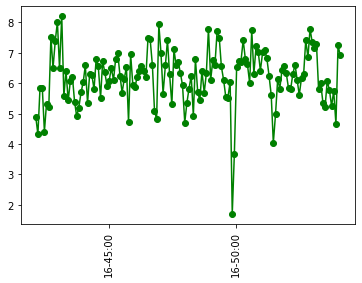

In [149]:
fig, ax = plt.subplots()
ax.plot(wd1_dna.GMT_Time[1400:8500:50],wd1_dna.wind_speed[1400:8500:50],'g-o')
plt.rcParams["date.autoformatter.minute"] = "%H:%M:%S"
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H-%M:%S"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H-%M-%S"))
_=plt.xticks(rotation=90) 

In [372]:
wd1_dna.groupby([wd1_dna["GMT_Time"].dt.hour])["wind_speed"].mean()*1.943

GMT_Time
16    11.841624
17    14.002259
18    13.737551
Name: wind_speed, dtype: float64

In [531]:

buoy=pd.read_table('gal.csv')

In [532]:
buoy.iloc[0]

Date/Time         2021-04-18 00:04:00
 Speed (knots)                   0.34
 Dir (true)                       160
Name: 0, dtype: object

In [533]:
buoy.columns[1]

' Speed (knots)'

In [475]:
min(buoy.speed[1:50])

'0.03'

In [534]:
buoy.head()

,Date/Time,Speed (knots),Dir (true)
0,2021-04-18 00:04:00,0.34,160
1,2021-04-18 00:10:00,0.35,159
2,2021-04-18 00:16:00,0.32,161
3,2021-04-18 00:22:00,0.24,160
4,2021-04-18 00:28:00,0.20,176


In [535]:
list(buoy.columns.values)

['Date/Time', ' Speed (knots)', ' Dir (true)']

In [536]:
buoy.columns=['date','speed','dir']

In [528]:
buoy.date[190]

'2021-04-30 19:05:00'

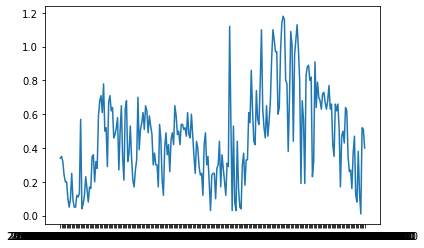

In [538]:
plt.plot(buoy.date,buoy.speed)

In [539]:
buoy["GMT_Time"] = pd.to_datetime(buoy['date'])

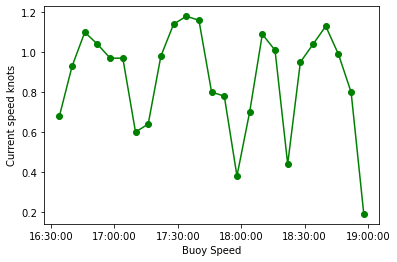

In [549]:
plt.plot(buoy["GMT_Time"][165:190], buoy.speed[165:190],'-go')
plt.ylabel('Current speed knots')
plt.xlabel('Buoy Speed')
plt.savefig('buoy.png')


In [542]:
np.mean(buoy.speed[165:19])

0.8675999999999999

In [543]:
0.86/1.943

0.442614513638703

In [816]:
pwd

'/Users/qfm954/Dropbox/USCG/Lat-Lon_Leeway/GALVESTONTEST3_APRIL182021'

In [905]:
#header_columns=["a","b","c","d","e","f","g","i","j"]
df2=pd.read_csv('Tank1.csv',sep=',')
#df2 = df.iloc[:, 0].str.split(',', expand=True)
#df2.columns = [n.replace('"', '') for n in df.columns.str.split(',')[0]]
#wind1.columns=['a','b','c','d','e','f','g','h','i']

In [913]:
df2.columns[1]

'Unnamed: 1'

In [862]:
wind1

,Unnamed: 0,"%time,field.data1,data2,data3,data4,data5,data6,data7"
0,0,"1618763951934012262,1618763951.93,P,-004.909,..."
1,1,"1618763952034606301,1618763952.03,P,-005.069,..."
2,2,"1618763952134736737,1618763952.13,P,-005.291,..."
3,3,"1618763952237749693,1618763952.23,P,-005.418,..."
4,4,"1618763952340727191,1618763952.33,P,-005.608,..."
...,...,...
16378,290,"1618765589135110572,1618765589.13,P,+004.052,..."
16379,291,"1618765589238787715,1618765589.23,P,+004.145,..."
16380,292,"1618765589336168340,1618765589.33,P,+003.960,..."
16381,293,"1618765589436594469,1618765589.43,P,+003.635,..."


In [901]:
names

[['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9']]

In [835]:
wind1

,0
0,"1618763951934012262,1618763951.93,P,-004.909,..."
1,"1618763952034606301,1618763952.03,P,-005.069,..."
2,"1618763952134736737,1618763952.13,P,-005.291,..."
3,"1618763952237749693,1618763952.23,P,-005.418,..."
4,"1618763952340727191,1618763952.33,P,-005.608,..."
...,...
65503,"1618770501434102333,1618770501.43,P,+001.991,..."
65504,"1618770501534538862,1618770501.53,P,+001.475,..."
65505,"1618770501636070412,1618770501.63,P,-003.452,..."
65506,"1618770501734671120,1618770501.73,P,-003.141,..."


In [1]:
# import os
# import io
# import re
# from pathlib import Path
# import datetime as dt
# import shutil
# import math
# import cmath
# from functools import wraps
# from operator import itemgetter

# import pandas as pd
# import numpy as np
# import matplotlib as mtpl
# import matplotlib.pyplot as plt
# import matplotlib.animation as animation
# import cartopy.io.img_tiles as img_tiles
# import geopy.distance as distance

# import geopandas
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature

# from env import MAPBOX_USER, MAPBOX_TOKEN, MAPBOX_MAP_ID

# # the argument dictionary for the wind data, mostly for loading the data from
# # the CSV files
# wind_args = {"x_cols": {"time": {"name": "infer",
#                              "unit": "CTZ"}},
#              "y_cols": {"wind_x_velocity": {"name": "infer",
#                                        "unit": "m/s"},
#                         "wind_y_velocity": {"name": "infer",
#                                        "unit": "m/s"},
#                         "wind_z_velocity": {"name": "infer",
#                                        "unit": "m/s"},
#                         "wind_speed": {"name": "infer",
#                                        "unit": "m/s"}},
#          "header_row": None,
#          "col_names": ["time", "wind_x_velocity", "wind_y_velocity", "wind_z_velocity",
#                        "temperature"],
#          # "use_cols": [1, 2, 3, 5],
#          "use_cols": [0, 3, 4, 5, 7],
#          "output": "show"}

# # the argument dictionary for loading the GPS data
# gps_args = {"filename_settings": {"base_headline.csv": {"col_names": ["time", "tow", "heading"],
#                                                            "use_cols": [1, 5, 6]},
#                                   "vel_ned.csv": {"col_names": ["n", "e", "d",
#                                                                 "h_accuracy", 
#                                                                 "v_accuracy"],
#                                                   "use_cols": [6, 7, 8, 9, 10]},
#                                   "pos_llh.csv": {"col_names": ["latitude", "longitude", "height"],
#                                                   "use_cols": [6, 7, 8]},
#                                   "imu_raw.csv": {"col_names": ["tow_f", "x_acceleration",
#                                                                 "y_acceleration", "z_acceleration",
#                                                                 "x_gyr", "y_gyr", "z_gyr"],
#                                                   "use_cols": [6, 7, 8, 9, 10, 11, 12]}},
#         "header_row": None,
#         "skip_rows": [0],
#         "x_cols": {"time": {"name": "infer", "unit": "CTZ"},
#                    "id": {"name": "infer", "unit": ""}},
#         "y_cols": {"x_acceleration": {"name": "infer", "unit": "m/s^2"},
#                    "y_acceleration": {"name": "infer", "unit": "m/s^2"},
#                    "z_acceleration": {"name": "infer", "unit": "m/s^2"},
#                    "longitude": {"name": "infer", "unit": "Degrees"},
#                    "latitude": {"name": "infer", "unit": "Degrees"}}}


# def main():
#     # directories
#     base_dir = r"C:\Users\thanh\OneDrive - University of Texas at San Antonio\CoastGuard"
    
#     # these are the folders inside that directory to load data from
#     dir_names = [
#             "Galveston3_Part1",
#             "Galveston3_Part2"
#             ]
#     project_directories = [os.path.join(base_dir, dir_name) for dir_name in dir_names]

#     # drops columns for saving the CSV
#     cols_to_drop = [
#             "level_0",
#             "index",

#             "tow",
#             "tow_f",
#             "height",
#             "wind_z_velocity",
#             "x_acceleration",
#             "y_acceleration",
#             "z_acceleration",
#             "x_gyr",
#             "y_gyr",
#             "z_gyr",
#             "h_accuracy",
#             "v_accuracy",
#             "n",
#             "e",
#             "d",
#             "temperature",
#             ]

#     # loads all of the data
#     for base_dir in project_directories:

#         # gets the case name
#         case_name = os.path.split(base_dir)[1]

#         # combines the data
#         # combined_df, wind_df, gps_df = main_processor(base_dir)

#         # loads the gps data
#         gps_data = GPSData(data_locs=base_dir, **gps_args)

#         # adds GMT time column
#         gps_data.df["GMT_time"] = gps_data.df["time"] + dt.timedelta(hours=12)
#         gps_data.df["GMT_time"] = gps_data.df["GMT_time"].dt.time

#         # prints the graph
#         if (not gps_data.df.empty):

#             # plots the graph
#             # you can change the plot_every to modify how many points to plot
#             # (in this case you are plotting every 100th point)
#             gps_data.plot_gps_graph(title=case_name, output="show", plot_every=100, **gps_args)

#             # file_name = os.path.split(wind_dir)[1] + "_filtered" + ".csv"

#         print(f"\n{case_name}\n")


# def main_processor(base_dir):

#     # loads the wind file
#     wind_file = os.path.join(base_dir, "wind", "wind_data.csv")
#     wind_df = fix_one_column_wind(wind_file, **wind_args)
#     wind_data = WindData(df=wind_df)

#     # loads the gps data
#     gps_data = GPSData(data_locs=base_dir, **gps_args)

#     # merges the gps and wind data
#     merged_data = pd.merge_asof(wind_data.df, gps_data.df, on="time")
#     merged_data.dropna(inplace=True)

#     # drops columns
#     merged_data.drop(cols_to_drop, axis=1, inplace=True)

#     # drops headers that have errors
#     merged_data = merged_data[merged_data["heading"] != 0]

#     # gets the corrected x and y velocities
#     merged_data["wind_x_velocity"], merged_data["wind_y_velocity"], \
#     merged_data["wind_polar_r"], merged_data["wind_polar_radians"] = \
#         GPSData.convert_relative_to_absolute_north(merged_data["wind_x_velocity"],
#                                                    merged_data["wind_y_velocity"],
#                                                    merged_data["heading"])

#     # renames x to u and v to u
#     merged_data.rename({"wind_x_velocity": "wind_u_velocity",
#                         "wind_y_velocity": "wind_v_velocity",
#                         "LO_lat": "latitude",
#                         "LO_lon": "longitude",},
#                         axis=1, inplace=True)

#     # adds GMT time column
#     merged_data["GMT_time"] = merged_data["time"] + dt.timedelta(hours=12)
#     merged_data["GMT_time"] = merged_data["GMT_time"].dt.time

#     # the index range
#     # start_time = dt.time(7, 25, 52, microsecond=419 * 1000)
#     # end_time = dt.time(8, 27, 57, microsecond=822 * 1000)
#     # filtered_by_time = merged_data["GMT_time"].between(start_time, end_time)
#     # merged_data = merged_data[filtered_by_time]

#     return merged_data, wind_data, gps_data


# def fix_one_column_wind(wind_file, **wind_args):
#     # reads the base wind file
#     df = pd.read_csv(wind_file)

#     # gets new column names and values
#     col_vals = list(df[df.columns[1]].dropna())

#     # creates the string IO object and writes the data with newlines
#     col_vals_as_file = io.StringIO()
#     col_vals_as_file.write("\n".join(col_vals))
#     col_vals_as_file.seek(0)

#     # now creates the fixed dataframe
#     new_df = pd.read_csv(col_vals_as_file, error_bad_lines=False,
#                          usecols=wind_args["use_cols"],
#                          names=wind_args["col_names"],
#                          # dtype=wind_args["dtype"]
#                          )

#     numeric_cols = [
#             "time",
#             "wind_x_velocity",
#             "wind_y_velocity",
#             "wind_z_velocity",
#             "temperature",
#             ]
#     for numeric_col in numeric_cols:
#         new_df[numeric_col] = pd.to_numeric(new_df[numeric_col], errors="coerce")
#     new_df.dropna(inplace=True)

#     return new_df


# # DECORATORS
# def _run_inplace_method(func):

#     @wraps(func)
#     def inner(self, df="infer", inplace=True, *args, **kwargs):
#         if not isinstance(df, pd.DataFrame) and df == "infer":
#             df = self.df

#         if not inplace:
#             df = df.copy()

#         func(self, df=df, *args, **kwargs)

#         if not inplace:
#             return df

#     return inner


# def _run_graphing_method(func):

#     @wraps(func)
#     def inner(self, df="infer", x_cols="infer", y_cols="infer",
#               excluded_pairs=None, output="show", display_lines=True,
#               title=str(dt.datetime.now()),
#               *args, **kwargs):

#         if df == "infer":
#             df = self.df

#         if x_cols == "infer":
#             x_cols = self.x_cols
#         if not isinstance(x_cols, dict):
#             x_cols = {x_cols[0]: x_cols[1]}

#         if y_cols == "infer":
#             y_cols = self.y_cols
#         if not isinstance(y_cols, dict):
#             y_cols = {y_cols[0]: y_cols[1]}

#         if excluded_pairs is None:
#             excluded_pairs = {}

#         # CONVERSION: time column to formattable type
#         try:
#             df = df.copy()
#             df["time"] = pd.to_datetime(df["time"].values.astype("datetime64[D]"))
#         except KeyError:
#             pass

#         func(self, df=df, x_cols=x_cols, y_cols=y_cols,
#                     excluded_pairs=excluded_pairs, *args, **kwargs)

#         # shows graph
#         if output is None:
#             pass
#         elif output == "show":
#             plt.show()
#         elif output == "save":
#             print("hello! saving")
#             plt.savefig(title + ".png")

#     return inner


# def _run_data_loading_method(func):

#     @wraps(func)
#     def inner(self, file_path, header_row="infer", col_names="infer", use_cols="infer",
#             col_name_transformations="infer",
#               *args, **kwargs):


#         if header_row == "infer":
#             header_row = self.header_row

#         if col_names == "infer":
#             col_names = self.col_names
#         # checks if there are conditional columns based on the filename
#         elif isinstance(col_names, dict):
#             try:
#                 col_names = col_names[file_path]
#             except KeyError:
#                 raise FileColumnsNotFoundError

#         if use_cols == "infer":
#             use_cols = self.use_cols

#         if col_name_transformations == "infer":
#             col_name_transformations = self.col_name_transformations

#         # gets custom filename settings
#         try:
#             file_name = os.path.split(file_path)[1]
#             filename_settings = kwargs["filename_settings"][file_name]

#             use_cols = filename_settings.get("use_cols", use_cols)
#             col_names = filename_settings.get("col_names", col_names)
#             col_name_transformations = filename_settings.get("col_name_transformations",
#                                                              col_name_transformations)
#         except KeyError:
#             pass

#         return func(self, file_path, header_row=header_row, col_names=col_names, use_cols=use_cols,
#                     col_name_transformations=col_name_transformations, *args,
#                     **kwargs)

#     return inner

# # EXCEPTIONS
# class NoTimeColumnError(Exception):
#     pass


# class NotGPSFileError(Exception):
#     pass


# class ParametricGraphLengthException(Exception):
#     pass


# class FileColumnsNotFoundError(Exception):
#     pass


# # DATA CLASSES
# class CustomData():
#     def __init__(self, df=None, data_locs=None, x_cols=None, y_cols=None,
#                  extension=".csv", use_cols=None, header_row=0, col_names=None,
#                  col_name_transformations=None, drop_duplicates=True,
#                  load_data=True, **kwargs):

#         # basic values
#         self.df = df
#         self.data_locs = data_locs
#         self.x_cols = x_cols
#         self.y_cols = y_cols

#         # data loading variables
#         self.extension = extension
#         self.use_cols = use_cols
#         self.header_row = header_row
#         self.col_names = col_names
#         self.col_name_transformations = col_name_transformations

#         # turns mutable arg into its correct form
#         if self.col_name_transformations is None:
#             self.col_name_transformations = {}

#         # checks if the data locations var was not a list
#         if not isinstance(data_locs, list):
#             self.data_locs = [data_locs]

#         # checks if the dataframe needs to be loaded
#         if isinstance(self.df, pd.DataFrame):
#             self.df = self.process_df(df)
#         elif self.data_locs and load_data:
#             self.df = self.load_data(self.data_locs, **kwargs)

#             # drops duplicates
#             if drop_duplicates:
#                 try:
#                     self.df.drop_duplicates(subset=["id"], inplace=True)
#                 except KeyError:
#                     pass

#     def __dic_name_prettifier(self, dic):
#         """
#         Internal function that prettifies a dictionary's names

#         Parameters
#         ----------
#         dic (dict)
#             Contains a dictionary in the format of {"VAR_NAME": {"name": "PRETTY
#             NAME", "unit": "UNIT"}}
#             The name key can either be omitted or explicitly labeled as "infer"
#             to be automatically determined by this function
#         """
#         if dic:
#             for key, val in dic.items():
#                 try:
#                     if val["name"] != "infer":
#                         continue
#                 except ValueError:
#                     pass
#                 val.update({"name": prettify_var_name(key)})

#         return dic

#     @property
#     def y_cols(self):
#         return self.__y_cols

#     @y_cols.setter
#     def y_cols(self, y_cols):
#         self.__y_cols = self.__dic_name_prettifier(y_cols)

#     @property
#     def x_cols(self):
#         return self.__x_cols

#     @x_cols.setter
#     def x_cols(self, x_cols):
#         self.__x_cols = self.__dic_name_prettifier(x_cols)

#     def load_data(self, data_locs, **kwargs):

#         # loads the data and processes it
#         df = self.concatenate_dataframes_from_files(data_locs,
#                                                     func=self.process_df,
#                                                     inplace=True,
#                                                     **kwargs)
#         return df

#     def process_df(self, df, *args, **kwargs):
#         try:
#             # tries to convert time from nanoseconds since the epoch to a
#             # timedelta
#             df["time"] = dt.datetime(1970, 1, 1) + pd.to_timedelta(df["time"])
#         except KeyError:
#             pass
#         return df

#     @_run_data_loading_method
#     def load_dataframe(self, file_path, header_row="infer", col_names="infer",
#                        use_cols="infer", col_name_transformations="infer",
#                        skip_rows=None, **kwargs):

#         # loads the file
#         df = pd.read_csv(
#             file_path,
#             usecols=use_cols,
#             header=header_row,
#             names=col_names,
#             skiprows=skip_rows
#         )

#         return df

#     def concatenate_dataframes_from_files(self, data_locs, df_func=None,
#                                           **kwargs):

#         # the list of dataframes
#         data_frames = []

#         # iterates over data files
#         kwargs["extension"] = kwargs.pop("extension", self.extension)
#         for df_file in find_files(data_locs, **kwargs):

#             # loads the dataframe
#             df = self.load_dataframe(df_file, **kwargs)

#             # calls any functions that might be specified
#             if df_func:
#                 df = df_func(df=df, file_path=df_file)

#             # checks the dataframe is not empty
#             if not df.empty:
#                 data_frames.append(df)

#         # concatenates all the dataframes
#         concatenated_dfs = pd.concat(data_frames)

#         return concatenated_dfs

#     def merge_dataframes_from_files(self, data_locs, func=None, **kwargs):

#         # turns locations into a list if it isn't already
#         if not isinstance(data_locs, list):
#             data_locs = [data_locs]

#         # the list of dataframes
#         df = None

#         # iterates over data files
#         for df_file in find_files(data_locs, **kwargs):

#             # loads the dataframe
#             df_part = self.load_dataframe(data_file, **kwargs)

#             # calls any functions that might be specified
#             if func:
#                 func(df, df_file)

#             df.merge(df_part, **kwargs)

#         # concatenates all the dataframes
#         return df

#     def __get_col_vals(self, col):
#         key = col[0]
#         name = col[1]["name"]
#         unit = col[1]["unit"]
#         return key, name, unit

#     def __set_title_and_labels(self, axis, x_col, y_col=None, title_note="",y_axis_name=None):
#             # variables
#             x_key, x_name, x_unit = self.__get_col_vals(x_col)

#             # sets the title
#             axis.set_xlabel(x_name + " (" + x_unit + ")")

#             if y_axis_name:
#                 axis.set_title((x_name + " versus " + y_axis_name + title_note))
#                 axis.set_ylabel(y_axis_name)
#             else:
#                 y_key, y_name, y_unit = self.__get_col_vals(y_col)
#                 axis.set_title((x_name + " versus " + y_key + title_note))
#                 axis.set_ylabel(y_name + " (" + y_unit + ")")

#     def __graphing_x_component(self, num_x_subplots, num_y_subplots):
#         fig, axes = plt.subplots(num_x_subplots, num_y_subplots)
#         fig.set_figheight(9)
#         fig.set_figwidth(16)

#         return fig, axes

#     def __graphing_y_component(self, df, axis, x_col, y_col, excluded_pairs,
#                                fmt=None, combined=False, display_lines=True):
#         # sets the x names
#         x_key, x_name, x_unit = self.__get_col_vals(x_col)
#         # sets the y names
#         y_key, y_name, y_unit = self.__get_col_vals(y_col)

#         # checks if lines should be removed
#         params = []
#         if not display_lines:
#             params.append(",")

#         # checks if this x-y combination shouldn't be graphed
#         try:
#             if y_key in excluded_pairs[x_key]:
#                 return
#         except KeyError:
#             pass

#         # plots the data
#         if combined:
#             y_label = y_name + "(" + y_unit + ")"
#             lines = axis.plot(df[x_key], df[y_key], *params, label=y_label)
#         else:
#             lines = axis.plot(df[x_key], df[y_key], *params)

#         # sets the format
#         if fmt:
#             axis.xaxis.set_major_formatter(fmt)

#     def scale_df_by_factor(self, data, scale_factor):
#         """
#         Helps scale DFs by frequency, meaning if one file was 20 HZ and another
#         was 40 HZ it would make them the same length
#         """
#         if scale_factor != 1:
#             # iterates over the new length of the series and creates the new
#             # series
#             new_length = math.floor(len(data) * scale_factor)
#             new_data = pd.DataFrame(columns=data.columns)
#             for i in range(new_length):
#                 old_index = math.floor(i / scale_factor)
#                 old_data = data.iloc[old_index, :]
#                 new_data = new_data.append(old_data)
#             new_data = new_data.reset_index()
#             return new_data
#         else:
#             return data

#     @_run_graphing_method
#     def plot_traditional_graphs(self, df="infer", x_cols="infer", y_cols="infer",
#                                 display_lines=True, title_note="",
#                                 fmt=mtpl.dates.DateFormatter("%H:%M"),
#                                 excluded_pairs=None, output="show", **kwargs):

#         # gets the number of subplots based on the number of y columns
#         num_plots = len(y_cols) * len(x_cols) - sum([excluded for excluded in
#                                                      excluded_pairs.values()])
#         num_y_values = len(y_cols)
#         num_y_subplots = 1 + num_plots // 4
#         num_x_subplots = math.ceil(num_plots / num_y_subplots)

#         for x_col in x_cols.items():

#             fig, axes = self.__graphing_x_component(num_x_subplots, num_y_subplots)

#             # creates the subplots
#             axes = np.array(axes).flatten()

#             # iterates over each graph
#             for axis, y_col in zip(axes, y_cols.items()):

#                 # gets titles
#                 self.__set_title_and_labels(axis, x_col, y_col=y_col, title_note=title_note)

#                 # graphs y values
#                 self.__graphing_y_component(df, axis, x_col, y_col,
#                                             excluded_pairs, fmt)

#     @_run_graphing_method
#     def plot_combined_graph(self, y_axis_names, df="infer", x_cols="infer", y_cols="infer",
#                             display_lines=True, title_note="",
#                             excluded_pairs=None, fmt=mtpl.dates.DateFormatter("%H:%M"),
#                             **kwargs):

#         if not isinstance(y_axis_names, list):
#             y_axis_names = [y_axis_names]

#         if len(y_axis_names) != len(x_cols):
#             raise Exception(f"The number of y_axis_names: {len(y_axis_names)} \
#                     and graphs to plot: {len(x_cols)} are mistmatched")

#         for y_axis_name, x_col, in zip(y_axis_names, x_cols.items()):

#             # creates the subplots
#             fig, axis = self.__graphing_x_component(1, 1)

#             # TODO
#             self.__set_title_and_labels(axis, x_col, title_note,
#                                         y_axis_name=y_axis_name)

#             # iterates over each graph
#             for y_col in y_cols.items():

#                 # TODO
#                 self.__graphing_y_component(df, axis, x_col, y_col,
#                                             excluded_pairs, fmt, combined=True)

#             # enables a legend
#             axis.legend()

#     @_run_graphing_method
#     def plot_3d_graph(self, df="infer", y_cols="infer", x_cols=None,
#             title_note="", **kwargs):

#         # checks the list is of length three
#         if len(y_cols) != 3:
#            raise ParametricGraphLengthException
       
#         # creates the 3d figure
#         fig = plt.figure()
#         fig.set_figheight(9)
#         fig.set_figwidth(16)
#         ax = fig.gca(projection="3d")

#         # gets the three variables to plot
#         x, y, z = [df[var] for var in y_cols.keys()]
#         labels = [y_val["name"] for y_val in y_cols.values()]

#         # sets the labels
#         ax.set_xlabel(labels[0])
#         ax.set_ylabel(labels[1])
#         ax.set_zlabel(labels[2])

#         # plots the data
#         lines = ax.plot(x, y, z, ",")

#         # sets the title
#         title = " versus ".join(labels)
#         ax.set_title(title)

#         # sets legend
#         ax.legend()

#         # plt.savefig(title + ".png")
#         # plt.show()

#     def print_graphs(self, title, y_axis_names, df="infer", x_cols="infer",
#                      y_cols="infer", **kwargs):

#         # traditional graphs
#         traditional_title = "traditional_graph_" + title + ".png"
#         self.plot_traditional_graphs(df, x_cols, y_cols, title=traditional_title, **kwargs)

#         # combined graph
#         combined_title = "combined_graph_" + title + ".png"
#         self.plot_combined_graph(df, x_cols, y_cols, y_axis_names=y_axis_names,
#                                  title=combined_title, **kwargs)

#         # 3d graph
#         three_d_title = "3d_graph_" + title + ".png"
#         try:
#             self.plot_3d_graph(df, x_cols, y_cols, title=three_d_title)
#         except Exception:
#             pass

#     def __str__(self):
#         return str(self.df)


# class GPSData(CustomData):
#     def __init__(self, **kwargs):
#         # the subfolder under each case that holds the 
#         self.folder_name = "piksi"

#         # everything at 5 HZ except for IMU raw at 2 HZ
#         self.file_names = {
#                 "vel_ned.csv": 1,
#                 "base_headline.csv": 1,
#                 "pos_llh.csv": 1,
#                 "imu_raw.csv": 2.5,
#                 }

#         super().__init__(**kwargs)

#     def process_df(self, df, freq, *args, **kwargs):
#         df = super().process_df(df, *args, **kwargs)
#         # scales data
#         try:
#             df = self.scale_df_by_factor(df, freq)
#         except Exception as e:
#             print(f"Error when scaling by frequency: {str(e)}")

#         # converts heading to degrees
#         try:
#             # old_heading = df["heading"]
#             df["heading"] = df["heading"] / 1000
#             # print(old_heading[df["heading"] == 0])
#             # print("\n\n\n\n")
#         except KeyError:
#             pass

#         return df

#     def post_process_df(self, df):
#         # drops rows that aren't fully merged
#         df.dropna(inplace=True)

#         # sorts by time
#         try:
#             df = df.sort_values(by="time")
#         except KeyError:
#             pass

#         # resets index
#         df = df.reset_index()

#         return df

#     def load_data(self, data_locs, inplace=True, **kwargs):
#         # gets the args for the file types
#         filename_settings = kwargs.pop("filename_settings")

#         # derives the df value from the first file
#         scale_by = None

#         all_dataframes = pd.DataFrame()
#         for file_name, manual_frequency in self.file_names.items():

#             folder_dataframes = pd.DataFrame()

#             # gets the file-specific args
#             file_args = filename_settings[file_name]

#             for file_path in find_files(data_locs,
#                                         extension=file_name):

#                 # gets the data
#                 data = self.load_dataframe(file_path, **file_args, **kwargs)

#                 # gets the scale factor
#                 if scale_by == None:
#                     scale_by = len(data)
#                 frequency = scale_by / len(data)

#                 # processes the data

#                 processed_data = self.process_df(data, frequency)

#                 # adds the processed data to the current folders data frame
#                 folder_dataframes = pd.concat([folder_dataframes, processed_data], axis=1)

#             # adds the folder dataframes to the the list of all of the
#             # dataframes
#             all_dataframes = pd.concat([all_dataframes, folder_dataframes], axis=1)

#         all_dataframes = self.post_process_df(all_dataframes)

#         return all_dataframes

#     def get_gps_plot_boundaries(self, longitude, latitude):
#         lon_min, lon_max = longitude.min(), longitude.max()
#         lat_min, lat_max = latitude.min(), latitude.max()
#         lon_center, lat_center = (lon_min + lon_max) / 2, (lat_min + lat_max) / 2

#         return lon_min, lon_max, lat_min, lat_max, lon_center, lat_center

#     @_run_inplace_method
#     def plot_gps_graph(self, df="infer", lon_col="longitude",
#                        lat_col="latitude", inplace=False, animated=True,
#                        title="", points_to_show=100, plot_style="r^",
#                        plot_every=1, **kwargs):

#         def get_graph_title(df, ax, frame):
#             # sets the time for readability
#             try:
#                 time = str(df["time"][frame].time())
#                 ax.set_title(title + " " + time)
#             except KeyError:
#                 pass

#         def init_plot_gps_points():
#             line.set_data([], [])
#             return line,

#         # function that can graph both animated and full data graphs
#         # pass -1 for it to graph the entire dataframe
#         def plot_gps_points(frame):
#             # checks if this frame should be plotted
#             get_graph_title(df, ax, frame)

#             # gets the min frame (so there is more than 1 point at once)
#             min_frame = 0 if frame < points_to_show else frame - points_to_show

#             # plots the GPS data
#             gps_points = gps_df.iloc[min_frame:frame:plot_every]
#             line.set_data(gps_points.longitude,
#                           gps_points.latitude)
#             return line,

#         # gets values and graph boundaries
#         lon_min, lon_max, lat_min, lat_max, lon_center, lat_center = self.get_gps_plot_boundaries(df[lon_col], df[lat_col])

#         # creates projection
#         # projection = ccrs.PlateCarree(central_longitude=lon_center)
#         projection = ccrs.PlateCarree()

#         # creates axis and adds the min and max lon and lat to display and
#         # adds gridlines
#         fig, ax = plt.subplots(figsize=(16, 9))
#         ax = plt.axes(projection=projection)
#         ax.set_extent([lon_min, lon_max, lat_min, lat_max],
#                       crs=ccrs.PlateCarree())
#         ax.gridlines(draw_labels=True, dms=True,
#                      x_inline=False, y_inline=False)

#         # adds background image tiles
#         map_tiles = img_tiles.MapboxTiles(MAPBOX_TOKEN, "satellite")
#         ax.add_image(map_tiles, 15)

#         # plots the graph
#         line, = ax.plot([], [], plot_style)

#         # gets the gps df
#         gps_df = df[[lon_col, lat_col]]
#         gps_df = geopandas.GeoDataFrame(gps_df,
#                                         geometry=geopandas.points_from_xy(gps_df.longitude,
#                                                                           gps_df.latitude),
#                                         crs=projection.proj4_init)

#         print(f"animated: {animated}")
#         if animated:
#             # only plots every n points
#             gps_df = gps_df[::plot_every]
#             ani = animation.FuncAnimation(fig, plot_gps_points,
#                                           init_func=init_plot_gps_points,
#                                           frames=len(gps_df),
#                                           interval=500, blit=False, repeat=False)
#             writer = animation.FFMpegWriter(fps=60)
#             file_name = title if title else str(dt.datetime.now())
#             ani.save(os.path.join("animations", file_name) + ".mp4",
#                      writer=writer)
#         else:
#             plot_gps_points(-1)

#         # plt.show()

#     def old_iterate_over_run_patient_case(self, func, base_dir=None, load_args={}, func_args={}):

#         if base_dir is None:
#             base_dir = self.data_locs

#         run_dirs = [os.path.join(base_dir, run_dir) for run_dir in os.listdir(base_dir) if
#                 run_dir.endswith("-run")]

#         for run_dir in run_dirs:
#             patient_dirs = [os.path.join(run_dir, patient_dir) for patient_dir in os.listdir(run_dir)]
#             run_name = prettify_var_name(run_dir.split(os.path.sep)[-1])

#             for patient_dir in patient_dirs:
#                 case_dirs = [os.path.join(patient_dir, case_dir) for case_dir in os.listdir(patient_dir)]
#                 patient_name = prettify_var_name(patient_dir.split(os.path.sep)[-1])

#                 for case_dir in case_dirs:
#                     case_name = prettify_var_name(case_dir.split(os.path.sep)[-1])

#                     # loads the data
#                     case_df = self.load_data([case_dir], inplace=False, **load_args)

#                     # checks if the title should be inferred
#                     title = func_args.get("title", " ".join([run_name, patient_name, case_name]))

#                     print(f"plotting{case_dir}")
#                     # runs the function provided
#                     # if not case_df.empty:
#                     func(df=case_df, title=title, **func_args)
#                     # else:
#                     #     print(f"ERROR: ID's on {case_dir} do not match up")
#                     print("\n")

#             shift_heading = np.vectorize(self._convert_relative_to_absolute_north)

#     @staticmethod
#     @np.vectorize
#     def convert_relative_to_absolute_north(x, y, heading_degrees):
#         # converts the x and y vals to polar format
#         polar_coord = cmath.polar(complex(x, y))

#         # subtracts the heading offset from the polar coordinates (rotates)
#         # new_angle = polar_coord[1] + (math.pi * 2 + math.radians(heading_degrees)) % (math.pi * 2)
#         new_angle = cmath.pi * 4 + polar_coord[1] - math.radians(heading_degrees)

#         # the rectangular coordinates
#         rect_coord = cmath.rect(polar_coord[0], new_angle)

#         # gets the radians
#         radians = (new_angle % (cmath.pi * 2)) / cmath.pi

#         # and returns them in a tupled, rounded format
#         return rect_coord.real, round(rect_coord.imag, 5), polar_coord[0], radians


# class WindData(CustomData):
#     def __init__(self, **kwargs):
#         # wind vals
#         # self.start_times = start_times
#         # self.run_day = run_day

#         super().__init__(extension=".txt", **kwargs)

#     def load_data(self, data_locs, inplace=True, **kwargs):

#         # loads the data and processes it
#         df = self.concatenate_dataframes_from_files(data_locs,
#                                                     df_func=self.process_df,
#                                                     **kwargs)
#         # sorts dataframe
#         df.sort_values(by="time", inplace=True)

#         return df

#     def process_df(self, df, inplace=True, **kwargs):
#         # gets the start time and adds the columns
#         # try:
#         #     start_time = self.get_start_time(file_path, **kwargs)
#         #     self.add_wind_columns(df, start_time, **kwargs)
#         # except NoTimeColumnError:
#         #     return pd.DataFrame()

#         # adds the speed column
#         df = self._add_speed_col(df)
#         df.dropna(inplace=True)

#         df = super().process_df(df)
#         return df

#     def get_start_time(self, file_path, **kwargs):
#         """
#         Gets a wind files start time

#         Parameters
#         ----------
#         file_path (str, filepath)
#             The files path, uses both the directory and name to get the time
#         """
#         # splits the file into the path and filename
#         directory, file_name = os.path.split(file_path)

#         # splits the directory into the bottom level folder
#         _, directory = os.path.split(directory)

#         # gets what the start time is
#         if directory == "galvmorn":
#             time_of_day = "morning"
#         elif directory == "galvafter":
#             time_of_day = "afternoon"
#         else:
#             raise NoTimeColumnError("There is no associated time of day \
#                                          for the folder {file_path}")

#         # gets the file name without underscores and an extension
#         stripped_file_name = "".join(os.path.splitext(file_name)[0].split("_"))

#         # returns the start time
#         try:
#             start_time = self.start_times[time_of_day][stripped_file_name]
#             return start_time
#         except KeyError:
#             raise NoTimeColumnError(f"No matching time for file: \
#                                          {file_name} (time of day: \
#                                          {time_of_day})")

#     def _add_speed_col(self, df):
#         @np.vectorize
#         def _speed_col(x, y):
#             result = np.sqrt(np.square(x) + np.square(y))
#             return result

#         # adds the speed col
#         speed = _speed_col(df["wind_x_velocity"],
#                            df["wind_y_velocity"])

#         # adds the speed to the dataframe
#         df["wind_speed"] = pd.Series(speed)

#         # assigns the new df
#         return df

#     def DEPRECATED_add_wind_columns(self, df, start_time, frequency_hertz=20,
#                          offset=dt.timedelta(hours=6),
#                          drop_na=True, inplace=True, **kwargs):
#         """
#         Adds several useful columns to a wind dataframe, based on existing data

#         Parameters:
#         -----------
#         df (pd.DataFrame)
#             The dataframe to operate on
#         start_time (dt.datetime)
#             The time to start the increments from
#         frequency_hertz (int)
#             The number of increments per second
#         drop_na (bool)
#             Whether or not to drop bad rows
#         inplace (bool)
#             Whether or not to perform the operation in place
#         """

#         # checks if there should be a return
#         if not inplace:
#             df = df.copy()

#         # adds the speed col
#         speed = _speed_col(df["wind_x_velocity"],
#                            df["wind_y_velocity"])

#         # adds the speed to the dataframe
#         df["wind_speed"] = pd.Series(speed)

#         # creates the time incremented from start_time
#         ms_freq = 1 / frequency_hertz * 1000
#         incremented_times = pd.timedelta_range(start=start_time,
#                 periods=len(df.index), freq=f"{ms_freq}ms")

#         # print(incremented_times)
#         df["time"] = self.run_day + incremented_times + offset

#         # drops nas
#         if drop_na:
#             df.dropna(inplace=True)

#         # assigns the new df
#         return df

#     def get_wind_statistics(self, df):
#         """
#         Assigns several statistics internally

#         Parameters
#         ----------
#         df (pd.DataFrame)
#             The dataframe to get statistics for
#         """

#         # the turbulent kinetic energy value
#         turbulent_kinetic_energy = 0

#         # the overall mean velocity
#         velocity_mean = 0

#         # gets the turbulence
#         for velocity in ["wind_x_velocity", "wind_y_velocity", "wind_z_velocity"]:

#             # gets the velocity column
#             velocity_col = df[velocity]

#             # the mean velocity
#             velocity_component_mean = velocity_col.mean()

#             # the difference between instantaneous and average velocity mean and
#             # variance
#             velocity_difference_mean = 0
#             velocity_difference_variance = 0

#             # gets the mean and variance
#             for row in self.df[velocity].iteritems():

#                 # the difference for the current row
#                 difference = row[1] - velocity_component_mean

#                 # adds to the mean and variance
#                 velocity_difference_mean += difference
#                 velocity_difference_variance += difference**2

#             # divides by the number of observations
#             num_observations = len(velocity_col)
#             velocity_difference_mean /= num_observations
#             velocity_difference_variance /= num_observations

#             # adds the difference variance to the turbulent kinetic energy
#             turbulent_kinetic_energy += velocity_difference_variance

#             # adds the squared velocity component to the mean velocity
#             velocity_mean += velocity_component_mean**2

#         # takes square root of the mean velocity
#         velocity_mean = math.sqrt(velocity_mean)

#         # halves the turbulent kinetic energy
#         turbulent_kinetic_energy /= 2

#         # calculates the root mean square of turbulent velocity fluctuations
#         rms_turbulent_velocity_fluctuations = math.sqrt(2 / 3 *
#                                                         turbulent_kinetic_energy)

#         # calculates the turbulence intensity/level
#         turbulence_intensity = rms_turbulent_velocity_fluctuations / velocity_mean

#         # assigns the values
#         self.velocity_mean = velocity_mean
#         self.rms_turbulent_velocity_fluctuations = rms_turbulent_velocity_fluctuations
#         self.turbulent_kinetic_energy = turbulent_kinetic_energy
#         self.turbulence_intensity = turbulence_intensity
#         return velocity_mean, rms_turbulent_velocity_fluctuations,
#         turbulent_kinetic_energy, turbulence_intensity


# # NON CLASS FUNCTIONS

# def combine_folders(base_dir, folder_permutations,
#                     strip_from_dest="2021-01-16-", get_before_underscore=True,
#                     **kwargs):

#     # the list of all folders to copy
#     folders_to_copy_from = []

#     # finds all the folder permutations (past the top level folders)
#     for layer in folder_permutations[1:]:

#         # checks if the list is empty
#         if not folders_to_copy_from:
#             folders_to_copy_from = layer

#         # else adds on to the existing folders
#         else:

#             # the list of replacements for the folder to copy
#             new_folders_to_copy_from = []

#             # iterates over each folder to copy
#             for folder_to_copy in folders_to_copy_from:

#                 # iterates over each file in the layer
#                 for subfolder in layer:
#                     # adds the new subfolder to the list
#                     new_subfolder = os.path.join(folder_to_copy, subfolder)
#                     new_folders_to_copy_from.append(new_subfolder)

#             # replaces the list
#             folders_to_copy_from = new_folders_to_copy_from

#     # creates the combined folder
#     try:
#         output_dir = os.path.join(base_dir, "combined_runs")
#         os.mkdir(output_dir)
#     # else exits as this program has already been run
#     except FileExistsError:
#         # return
#         pass

#     # the top level directories to copy from
#     top_level_dirs = [os.path.join(base_dir, top_level_dir) for top_level_dir
#                       in folder_permutations[0]]

#     # iterates over each subfolder
#     for subfolder in folders_to_copy_from:

#         # directory to copy from
#         copy_to = os.path.join(output_dir, subfolder)

#         # tries to make the directory in the combined data runs
#         try:
#             os.makedirs(copy_to)
#         # else it has already been made
#         except FileExistsError:
#             pass

#         # copies all the files from the subfolder path in each top level dir
#         for top_level_dir in top_level_dirs:

#             # directory to copy from
#             copy_from = os.path.join(top_level_dir, subfolder)

#             # tries copying folders in that directory
#             try:
#                 for folder_to_copy in os.listdir(copy_from):
#                     # gets its absolute path and copies it
#                     folder_to_copy_path = os.path.join(copy_from, folder_to_copy)

#                     # the name stripped of a user-defined string
#                     dest_dir_name = \
#                     str.join(*folder_to_copy.split(strip_from_dest))

#                     # checks if the directory name should be split before
#                     # underscore
#                     dest_dir_name = dest_dir_name.split("_")[0]

#                     # creates the absolute directory path
#                     folder_destination_path = os.path.join(copy_to,
#                                                            dest_dir_name)

#                     # tries to copy the file
#                     try:
#                         shutil.copytree(folder_to_copy_path,
#                                         folder_destination_path)
#                     except FileExistsError:
#                         pass
#             # passes if that is not a directory
#             except FileNotFoundError:
#                 pass


# def prettify_var_name(var_name, chars_to_split="_-"):
#     compiled_chars_to_split = re.compile(chars_to_split)
#     new_var_name = " ".join(re.split(compiled_chars_to_split, var_name)).title()
#     return new_var_name


# def find_files(data_locations, extension=".csv", starts_with="", **kwargs):

#     # iterates over each directory
#     for data_location in data_locations:

#         # checks if the location is a file
#         if os.path.isfile(data_location):
#             yield data_location

#         # else if the location is a directory
#         elif os.path.isdir(data_location):

#             # finds the files in the directory that are of the proper extension
#             match_pattern = starts_with + "*" + extension
#             for path in Path(data_location).rglob(match_pattern):
#                 yield path

#         # else it doesn'"t exist
#         else:
#             raise FileNotFoundError(f"The data location {data_location} does not exist")


# # DEPRECATED FUNCTIONS
# def DEPRECATED_old_data_main():

#     # the base directories
#     base_dir = os.path.join("/home/larva/Research/bhaganagar/wind-gps-data/data")
#     gps_dir = os.path.join(base_dir, "gps-data")
#     combined_runs_dir = os.path.join(base_dir, "gps-data", "combined_runs")
#     wind_dir = os.path.join(base_dir, "wind-data")

#     # a dictionary of start times
#     run_day = dt.datetime(2021, 1, 16)
#     start_times = {"morning": {
#                     "winddata1": dt.timedelta(hours=11, minutes=13),
#                     "winddata2": dt.timedelta(hours=11, minutes=25),
#                     "winddata3": dt.timedelta(hours=11, minutes=41),
#                     "winddata42": dt.timedelta(hours=12, minutes=39),
#                     "winddata5": dt.timedelta(hours=12, minutes=49),
#                     # "winddata6": dt.timedelta(hours=13, minutes=00),
#                     # "winddata7": dt.timedelta(hours=13, minutes=26),
#                     "winddata8": dt.timedelta(hours=13, minutes=38),
#                     "winddata9": dt.timedelta(hours=13, minutes=46),
#                   },
#                   "afternoon": {
#                     "winddata12": dt.timedelta(hours=16, minutes=2),
#                     "winddata2": dt.timedelta(hours=16, minutes=9),
#                     "winddata3": dt.timedelta(hours=16, minutes=18),
#                     "winddata42": dt.timedelta(hours=16, minutes=47),
#                     "winddata5": dt.timedelta(hours=16, minutes=54),
#                     "winddata6": dt.timedelta(hours=16, minutes=0),
#                     "winddata7": dt.timedelta(hours=17, minutes=9),
#                     "winddata8": dt.timedelta(hours=17, minutes=16),
#                   }}
#     wind_args.update({"run_day": run_day,
#                       "start_times": start_times})


#     # creates the major component wind graph
#     wind_data = WindData(data_locs=wind_dir, **wind_args)
#     # wind_data.print_graphs(y_axis_names="Wind Motion")

#     # combined_runs_dir = os.path.join(base_dir, "gps-data", "combined_runs", "Oscar_1", "Against_Current")
#     lidar_data = pd.read_csv(os.path.join(gps_dir, "Pythonized_LIDAR_Leeway_centroid_traj_2021-01-16-17-10-18_2.csv"))
#     lidar_data["tplot"] = pd.to_datetime(lidar_data["tplot"])

#     gps_data = GPSData(data_locs=gps_dir, **gps_args)

#     # merges the dataframes based on time
#     merged_data = pd.merge_asof(wind_data.df, gps_data.df, on="time").dropna()
#     merged_data.dropna().drop_duplicates(["x_gyr",
#                                           "y_gyr",
#                                           "z_gyr",
#                                           "wind_x_velocity",
#                                           "wind_y_velocity",
#                                           "wind_z_velocity",
#                                          ], inplace=True)

#     merged_lidar_data = pd.merge(lidar_data, merged_data, right_on="time", left_on="tplot").dropna()
#     merged_lidar_data["wind_x_velocity"], merged_lidar_data["wind_y_velocity"], merged_lidar_data["wind_polar_r"], merged_lidar_data["wind_polar_radians"] = GPSData.convert_relative_to_absolute_north(merged_lidar_data["wind_x_velocity"],
#                                                                                                       merged_lidar_data["wind_y_velocity"],
#                                                                                                       merged_lidar_data["heading"])

#     merged_lidar_data.drop(["level_0", "n", "e", "d", "h_accuracy",
#     "v_accuracy", "x_acceleration", "y_acceleration", "z_acceleration",
#     "wind_z_velocity", "temperature", "height", "tow_f", "index", "tow",
#     "x_gyr", "y_gyr", "z_gyr", "tplot", "stamp"], axis=1, inplace=True)
#     # merged_lidar_data = merged_lidar_data[((merged_lidar_data["time"] >= dt.datetime(2021, 1, 16, 23, 10, 18)) & (merged_lidar_data["time"] <= dt.datetime(2021, 1, 16, 23, 10, 46)))]

#     merged_lidar_data["wind_direction"] = merged_lidar_data["wind_polar_radians"] / math.pi * 180
#     merged_lidar_data.sort_values(by="time", inplace=True)
#     merged_lidar_data.rename(columns={"wind_x_velocity": "wind_u_velocity",
#                                       "wind_y_velocity": "wind_v_velocity"},
#                              inplace=True)

#     merged_lidar_data.to_csv("Lidar_wind_gps_data_23:10:18.4_to_23:10:46.6.csv", index=False)

# if __name__ == "__main__":
#     mtpl.use('TkAgg')

#     main()



ModuleNotFoundError: No module named 'cartopy'